In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit['visualization']
!pip install pylatexenc
!pip install qiskit-aer
!pip install qiskit_ibm_runtime
!pip install numpy
!pip install matplotlib
!pip install scipy
# !pip install qiskit-ib

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)

qc.draw('mpl')

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum",
                                token ="8f94da79454ec50dcf502a86cce6489a55dc1da429e7371e0fe805c885b67f228d9e7348d63d52fbdbbf3d6e0b78bb625d9f3caf333eefc74c484a00972fe183")

#QiskitRuntimeService.save_account(channel="ibm_quantum",
#                                  token="da13eebb1c9a9014b29f40b13f26675d59f8bbe98880605c33de602f3ea96939300176a2f9272b5f37e664650be49812a74a6e88b56f626b3e7e1e3dc946ced3")

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp

### Encoding the problem


Let the trail state be:

$$ (1/2L)\sum_{x1,x2} |x1,x2> $$

In [ ]:
# Defing the Parameters:

m = 940
L = 5
c = 0.8
w = 5
h = 1/ (2*m)

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

L = 5
num_qubits = 2 * L
q = QuantumRegister(num_qubits, "qreg")
#c = ClassicalRegister(num_qubits)
trail_circuit = QuantumCircuit(q)

for i in range(num_qubits):
    trail_circuit.h(q[i])

trail_circuit.draw('mpl')

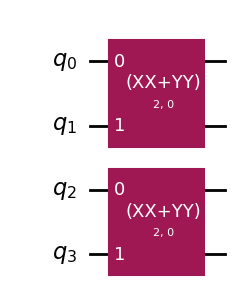

In [ ]:
def Kinetic_Energy(L, circuit, m):
    from qiskit.quantum_info import SparsePauliOp
    from qiskit_ibm_runtime import EstimatorV2 as Estimator
    from qiskit_ibm_runtime import QiskitRuntimeService
    from qiskit_ibm_runtime import EstimatorOptions
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

    # Adjust observables to ensure they span the correct number of qubits (2L)
    observables_x = ['I'*i + 'X'*2 + 'I'*(2*L - i - 2) for i in range(2*L - 1)]
    observables_y = ['I'*i + 'Y'*2 + 'I'*(2*L - i - 2) for i in range(2*L - 1)]
    observables = observables_x + observables_y

    operators = [SparsePauliOp(operator_string) for operator_string in observables]

    # Choosing the backend
    service = QiskitRuntimeService(channel ='ibm_quantum',
                                   token='deletethisandenteryouribmtoken')
    backend = service.backend("ibm_brisbane")

    # Transpilation
    pass_Manager = generate_preset_pass_manager(backend=backend, optimization_level=2)
    isa_circuit = pass_Manager.run(circuit)

    operators_transpiled_layout = [op.apply_layout(isa_circuit.layout) for op in operators]

    # Expectation Value
    options = EstimatorOptions()
    options.resilience_level = 1
    options.dynamical_decoupling.enable = True
    options.dynamical_decoupling.sequence_type = 'XY4'

    estimator = Estimator(backend, options)
    job = estimator.run([(isa_circuit, operators_transpiled_layout)])
    print(job.job_id())

    result = job.result()[0]
    values = result.data.evs
    energy = sum(values)
    h = 1/m
    kinetic_energy = 4*h - (h/2)*energy
    return kinetic_energy


In [ ]:
def Interaction_Energy(circuit, L, c):
    from qiskit.quantum_info import SparsePauliOp
    from qiskit_ibm_runtime import EstimatorV2 as Estimator
    from qiskit_ibm_runtime import EstimatorOptions
    from qiskit_ibm_runtime import QiskitRuntimeService
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

    # Ensure L is an integer and c is a float or int
    if not isinstance(L, int):
        raise ValueError("L must be an integer representing the lattice size.")
    if not isinstance(c, (float, int)):
        raise ValueError("c must be a number (float or int).")

    # Adjust observables to ensure they span the correct number of qubits (2L)
    observables = ['I'*i + 'Z'*2 + 'I'*(2*L - i - 2) for i in range(2*L - 1)]
    operators = [SparsePauliOp(operator_string) for operator_string in observables]

    # Set up backend
    service = QiskitRuntimeService(channel='ibm_quantum',
                                   token='deletethisandenteryouribmtoken')
    backend = service.backend("ibm_brisbane")

    # Transpilation
    pass_Manager = generate_preset_pass_manager(backend=backend, optimization_level=2)
    isa_circuit = pass_Manager.run(circuit)

    # Apply transpiled layout to operators
    operators_transpiled_layout = [op.apply_layout(isa_circuit.layout) for op in operators]

    # Set up Estimator options
    options = EstimatorOptions()
    options.resilience_level = 1
    options.dynamical_decoupling.enable = True
    options.dynamical_decoupling.sequence_type = 'XY4'

    # Create Estimator instance
    estimator = Estimator(backend, options)

    # Run the job
    job = estimator.run([(isa_circuit, operators_transpiled_layout)])
    print(job.job_id())

    # Get the result
    result = job.result()[0]
    values = result.data.evs

    # Calculate the interaction energy
    energy = sum(values)
    interaction_energy = (c / 4) * L + (c / 2) * energy
    return interaction_energy


In [ ]:
# Mod Value:
def mod(l, L):
  return l % L
def mod_value(l, L, c):
  center = (L - 1) / 2  # Calculate the center of the lattice
  pot_res =  (mod(l, L) - center) ** 2  # Compute the squared deviation
  pot_en = pot_res - (c/2)
  return pot_en

In [ ]:
def Potential_Energy(circuit, L, c, m, w):
    from qiskit.quantum_info import SparsePauliOp
    from qiskit_ibm_runtime import EstimatorV2 as Estimator
    from qiskit_ibm_runtime import EstimatorOptions
    from qiskit_ibm_runtime import QiskitRuntimeService
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

    # Choose backend
    service = QiskitRuntimeService(channel='ibm_quantum',
                                   token='deletethisandenteryouribmtoken')
    backend = service.backend("ibm_brisbane")

    # Observables construction (adjust to ensure they span the correct number of qubits)
    observables = ['I'*i + 'Z' + 'I'*(2*L - i - 1) for i in range(2*L)]
    operators = [SparsePauliOp(operator_string) for operator_string in observables]

    # Transpilation
    pass_Manager = generate_preset_pass_manager(backend=backend, optimization_level=2)
    isa_circuit = pass_Manager.run(circuit)
    operators_transpiled_layout = [op.apply_layout(isa_circuit.layout) for op in operators]

    # Execution with Estimator
    options = EstimatorOptions()
    options.resilience_level = 1
    options.dynamical_decoupling.enable = True
    options.dynamical_decoupling.sequence_type = 'XY4'

    estimator = Estimator(backend, options)
    job = estimator.run([(isa_circuit, operators_transpiled_layout)])
    print(job.job_id())

    # Get result
    result = job.result()[0]
    values = result.data.evs

    # Calculate energy
    energy = sum(values)  # Ensure the result sum is done correctly

    # Potential energy calculation
    res_pot = ((m * w**2) * energy) / 4
    potential_energy = (m * (w**2) * L * (L - 1) / 24) - res_pot

    return potential_energy


### Defining the Ansatz

In [ ]:
# Define the ansatz function, updated for dynamic qubit size
def ansatz(E_total, L, m, c):
    try:
        # Initialize classical wave function with uniform superposition
        Psi = np.ones((L, L)) / np.sqrt(L * L)  # Uniform superposition

        # Define the potential function for the lattice points
        def potential(i1, i2, L, m, w, c):
            V = 0.5 * m * w**2 * (i1**2 + i2**2)
            if i1 == i2:  # Interaction term when particles are at the same site
                V += c
            return V

        # Relaxation method to update wave function
        def update_wave_function(Psi, L, h, m, w, c, E_total, iterations=1000, tolerance=1e-6):
            for iteration in range(iterations):
                Psi_new = np.zeros_like(Psi)  # New wave function after iteration
                for i1 in range(1, L-1):  # Loop through lattice, avoiding boundary
                    for i2 in range(1, L-1):
                        # Compute nearest neighbors average
                        Psi_avg = (Psi[i1+1, i2] + Psi[i1-1, i2] + Psi[i1, i2+1] + Psi[i1, i2-1]) / 4.0
                        # Compute potential at the lattice point
                        V_i1_i2 = potential(i1, i2, L, m, w, c)
                        # Update the wave function using the relaxation method
                        Psi_new[i1, i2] = (4 * h * Psi_avg) / (4 * h + (V_i1_i2 - E_total))

                # Check for convergence
                if np.max(np.abs(Psi_new - Psi)) < tolerance:
                    print(f'Converged after {iteration+1} iterations.')
                    break

                Psi = Psi_new  # Update wave function for next iteration

            return Psi_new

        # Perform the relaxation method to get the converged wave function
        Psi_converged = update_wave_function(Psi, L, h, m, w, c, E_total)

        if Psi_converged is None:
            raise ValueError("Wave function update failed, no valid Psi_converged.")

        # Normalize the classical wave function
        norm_factor = np.linalg.norm(Psi_converged)
        if norm_factor == 0:
            raise ValueError("Normalization factor is zero, possible numerical instability.")

        Psi_normalized = Psi_converged.flatten() / norm_factor  # Flatten into a 1D array

        # Calculate the number of qubits needed for the given lattice size
        num_amplitudes = len(Psi_normalized)
        #num_qubits = int(np.ceil(np.log2(num_amplitudes)))  # Number of qubits needed
        num_qubits = 2*L
        # Ensure state vector has the correct size (power of 2)
        if len(Psi_normalized) < 2**num_qubits:
            Psi_normalized = np.pad(Psi_normalized, (0, 2**num_qubits - len(Psi_normalized)), 'constant')

        # Create a quantum circuit with the required number of qubits
        qc = QuantumCircuit(num_qubits)

        # Initialize the quantum state with the normalized wave function
        state_vector = Statevector(Psi_normalized)

        # Update here: Initialize the quantum circuit with the correct number of qubits
        if len(state_vector) == 2**num_qubits:
            qc.initialize(state_vector, range(num_qubits))
        else:
            raise ValueError(f"Statevector length {len(state_vector)} does not match 2**{num_qubits} qubits")

        return qc

    except Exception as e:
        print(f"Error in ansatz function: {e}")
        return None


In [ ]:
# Initial Guess

params = []
initial_energy = Kinetic_Energy(L, trail_circuit, m) + Interaction_Energy(trail_circuit, L, c) + Potential_Energy(trail_circuit, L, c, m, w)
params.append(initial_energy)
print(initial_energy)

In [ ]:
def cost_func(params, ansatz, L, m, c, estimator):
    """
    Return the estimated energy and update the ansatz with the obtained energy.

    Parameters:
        params (ndarray): Array of ansatz parameters (first parameter is E_total).
        ansatz (function): Ansatz function that generates a quantum circuit.
        L (int): Lattice size.
        m (float): Mass parameter.
        c (float): Coupling constant.
        estimator (Estimator): Estimator primitive instance.

    Returns:
        float: Energy estimate.
    """
    # Step 1: Get the energy (E_total) from params and update the ansatz
    E_total = params[0]  # First parameter is the E_total to update the ansatz
    qc = ansatz(E_total, L, m, c)  # Generate the quantum circuit based on this E_total

    # Step 2: Estimate the energy using the updated quantum circuit
    energy = Kinetic_Energy(L, qc, m) + Interaction_Energy(qc, L, c) + Potential_Energy(qc, L, c, m, w)

    # Step 3: Update E_total with the new energy (feedback loop)
    params[0] = energy  # Update params with the new E_total value

    # Step 4: Store cost history
    cost_history_dict["iters"] += 1
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy


In [ ]:
cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [ ]:
from scipy.optimize import minimize
import numpy as np
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, QiskitRuntimeService
# Initial parameter (E_total as the first parameter)
x0 = np.array([initial_energy])  # Initial guess for E_total (you can change this value)

backend = service.backend('ibm_brisbane')

with Session(service = service, backend=backend) as session:
    estimator = Estimator(backend)
    estimator.options.default_shots = 1000
    # Run the optimization using COBYLA
    result = minimize(
        cost_func,
        x0,
        args=(ansatz, L, m, c, estimator),  # Pass ansatz and other args
        method="COBYLA"
    )

# The result will hold the optimized energy and wave function
final_energy = result.fun  # The minimum energy found
final_params = result.x  # Final values of the parameters (including the optimized E_total)


In [ ]:
print(final_energy)

Till now we have calculated E_total using the VQE

In [ ]:
mu = m/2

In [ ]:
import numpy as np
from scipy.special import gamma

def calculate_relative_energy(E_total, omega):
    # Center of mass energy
    E_CM = 0.5 * omega  # Ground state energy of CM motion
    # Relative energy
    E_rel = E_total - E_CM
    return E_rel

def calculate_relative_momentum(E_rel, mu):
    # Relative momentum p
    p = np.sqrt(2 * mu * E_rel)
    return p

def busch_phase_shift(p, mu, omega):
    # Compute p * cot(δ) using the Busch formula
    term1 = gamma(0.25 - (p**2 / (4 * mu * omega)))
    term2 = gamma(0.75 - (p**2 / (4 * mu * omega)))
    p_cot_delta = (p**2 / (2 * mu * omega)) * (term1 / term2)
    return p_cot_delta

# Example parameters

# Step 1: Calculate relative energy
E_rel = calculate_relative_energy(final_energy, w)

# Step 2: Calculate relative momentum
p = calculate_relative_momentum(E_rel, mu)

# Step 3: Calculate phase shift using Busch formula
p_cot_delta = busch_phase_shift(p, mu, w)
print(f"p * cot(δ): {p_cot_delta}")


In [ ]:
# Calculating Delta

deltas = []
delta = np.arctan(1 / (p_cot_delta / p))
print(f"Phase shift δ: {delta}")

deltas.append(delta)